# Comparing the performance of QAOA with classical algorithms for MaxCut

MaxCut has been extensively studied, with multiple classical algorithms available. QAOAKit includes an implementation of a recent explicit vector algorithm for high-girth MaxCut (https://scirate.com/arxiv/2108.12477), as well as a wrapper around Goemans-Williamson implementation in Qiskit.

We can compare the performance of these algorithms with QAOA on 3-regular graphs. Available Goemans-Williamson implementation does not return the expected cut, so we will compute the expectation as the average cut from a sample.

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from functools import partial
from tqdm import tqdm
tqdm.pandas()

from QAOAKit import get_3_reg_dataset_table
from QAOAKit.utils import (
    maxcut_obj,
    get_adjacency_matrix,
)

# classical methods
from QAOAKit.classical import thompson_parekh_marwaha
from QAOAKit.qiskit_interface import goemans_williamson

def GW_expected(G):
    obj = partial(maxcut_obj, w=get_adjacency_matrix(G))
    soln = goemans_williamson(G, nsamples=1000)
    return np.mean([obj(x) for x in soln])

We will consider all non-isomorphic 3-regular graphs

In [2]:
df = get_3_reg_dataset_table().reset_index()

# only need to compute classical solution once per graph
df_classical = df[df['p_max'] == 1]

df_classical['C_{GW}'] = df_classical.progress_apply(lambda row: GW_expected(row['G']), axis=1)

100%|██████████| 4681/4681 [04:06<00:00, 18.98it/s]


In [3]:
df_classical['C_{TPM}'] = df_classical.progress_apply(lambda row: thompson_parekh_marwaha(row['G'], nsamples=1)[1] * row['G'].number_of_edges(), axis=1)

100%|██████████| 4681/4681 [00:48<00:00, 95.81it/s]


Let's merge this with results for higher values of `p` to compare them directly

In [4]:
df_p_2 = df[df['p_max'] == 2].set_index('pynauty_cert').add_suffix(' p=2')
df_classical = df_classical.set_index('pynauty_cert').merge(df_p_2, how='inner', left_index=True, right_index=True)

In [12]:
df_classical['Goemans-Williamson'] = df_classical['C_{GW}'] / df_classical['C_{true opt}']
df_classical['Thompson-Parekh-Marwaha'] = df_classical['C_{TPM}'] / df_classical['C_{true opt}']
df_classical['QAOA $p=1$'] = df_classical['C_opt'] / df_classical['C_{true opt}']
df_classical['QAOA $p=2$'] = df_classical['C_opt p=2'] / df_classical['C_{true opt}']

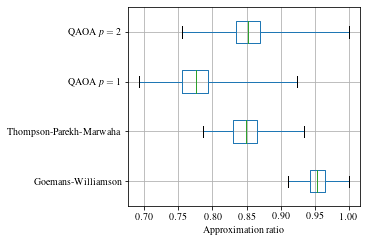

In [14]:
import matplotlib.pyplot as plt
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)


f, ax = plt.subplots(figsize=(1.5*6.92654/2, 6.92654/2))

df_classical.boxplot(
    column=[
        'Goemans-Williamson',
        'Thompson-Parekh-Marwaha',
        'QAOA $p=1$',
        'QAOA $p=2$',
    ],
    ax=ax,
    whis=(0,100),
    vert=False
)
plt.xlabel('Approximation ratio')
plt.tight_layout()
plt.savefig('classical_vs_quantum.pdf')

It looks like at `p=2` QAOA can match the performance of the Thompson-Parekh-Marwaha algorithm, but not Goemans-Williamson!